#**Import Library**

In [ ]:
pip install tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 36.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      

In [ ]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from collections import defaultdict

In [ ]:
print("\u2022 Using TensorFlow Version:", tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.13.0
• GPU Device Not Found. Running on CPU


# **Load Dataset**

### Load from Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/dataset 3 ast'

In [ ]:
label_counts = defaultdict(int)

for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    if os.path.isdir(label_path):
        # Hitung jumlah file dalam subfolder yang merupakan label
        label_counts[label] = len(os.listdir(label_path))

for label, count in label_counts.items():
    print(f"Label: {label}, Jumlah data: {count}")

Label: Bruises, Jumlah data: 131
Label: Burns, Jumlah data: 127
Label: Cut, Jumlah data: 118
Label: Abrasions, Jumlah data: 120
Label: Normal, Jumlah data: 130


### Display data label

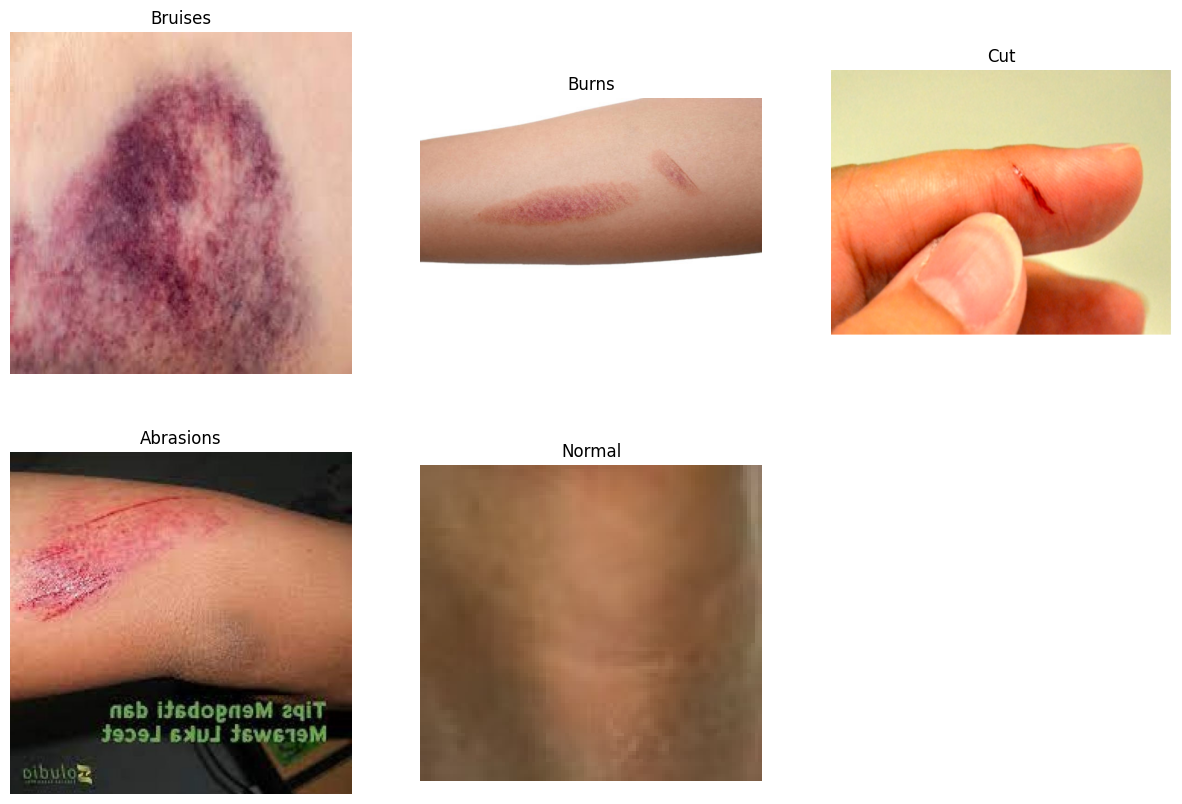

In [ ]:
# Display Example Images for Each Label
categories = os.listdir(data_dir)
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)
    first_image = os.listdir(folder_path)[0]
    img_path = os.path.join(folder_path, first_image)
    img = plt.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")

plt.show()

# **Preprocess Images and Prepare Data**

Set batch dan image size

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [ ]:
# Get list of image paths and labels
image_paths = []
labels = []

for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    for img_file in os.listdir(label_path):
        image_paths.append(os.path.join(label_path, img_file))
        labels.append(label)

Spliting data (80:10:10)

In [ ]:
# Split data into training (80%) and temp (20%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.1, stratify=labels, random_state=42
)

# Further split temp into validation (10%) and test (10%)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Total training images: {len(train_paths)}")
print(f"Total validation images: {len(val_paths)}")
print(f"Total test images: {len(test_paths)}")

Total training images: 563
Total validation images: 31
Total test images: 32


Prepocessing (normalize data) & shuffle batch

In [ ]:
def create_generator(image_paths, labels, image_size, batch_size):
    label_map = {label: idx for idx, label in enumerate(sorted(set(labels)))}
    num_classes = len(label_map)

    # normalization
    datagen = ImageDataGenerator(rescale=1./255)

    # Create generator from the given images and labels
    generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': image_paths, 'class': labels}),
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        classes=label_map,
        shuffle=True
    )
    return generator

train_generator = create_generator(train_paths, train_labels, IMAGE_SIZE, BATCH_SIZE)
validation_generator = create_generator(val_paths, val_labels, IMAGE_SIZE, BATCH_SIZE)
test_generator = create_generator(test_paths, test_labels, IMAGE_SIZE, BATCH_SIZE)

Found 563 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 32 validated image filenames belonging to 5 classes.


In [ ]:
class_labels = list(train_generator.class_indices.keys())
file_path = "class_labels.txt"

with open(file_path, "w") as file:
    for label in class_labels:
        file.write(label + "\n")

In [ ]:
print(train_generator.class_indices)

{'Abrasions': 0, 'Bruises': 1, 'Burns': 2, 'Cut': 3, 'Normal': 4}


# **Transfer Learning**

### Import base model

In [ ]:
# Transfer Learning with MobileNetV2 Base Model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze base model layers
base_model.trainable = False

### Custom layer model

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(len(categories), activation='softmax')
])

### Training model

In [ ]:
# Set the learning rate to decrease exponentially during the training process.
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)

# Creating Adam optimizer with learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 3574853 (13.64 MB)
Trainable params: 131

In [ ]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

Epoch 1/20
18/18 [==============================] - 33s 2s/step - loss: 1.4631 - accuracy: 0.5169 - val_loss: 0.8545 - val_accuracy: 0.7097
Epoch 2/20
18/18 [==============================] - 25s 1s/step - loss: 0.6007 - accuracy: 0.7851 - val_loss: 0.4903 - val_accuracy: 0.7742
Epoch 3/20
18/18 [==============================] - 26s 1s/step - loss: 0.3875 - accuracy: 0.8544 - val_loss: 0.3975 - val_accuracy: 0.8387
Epoch 4/20
18/18 [==============================] - 32s 2s/step - loss: 0.2991 - accuracy: 0.8863 - val_loss: 0.3877 - val_accuracy: 0.9032
Epoch 5/20
18/18 [==============================] - 25s 1s/step - loss: 0.1966 - accuracy: 0.9290 - val_loss: 0.4636 - val_accuracy: 0.8710
Epoch 6/20
18/18 [==============================] - 26s 1s/step - loss: 0.1704 - accuracy: 0.9414 - val_loss: 0.5217 - val_accuracy: 0.8387
Epoch 7/20
18/18 [==============================] - 26s 1s/step - loss: 0.1406 - accuracy: 0.9449 - val_loss: 0.3885 - val_accuracy: 0.9032
Epoch 8/20
18/18 [==

### Visualize Results

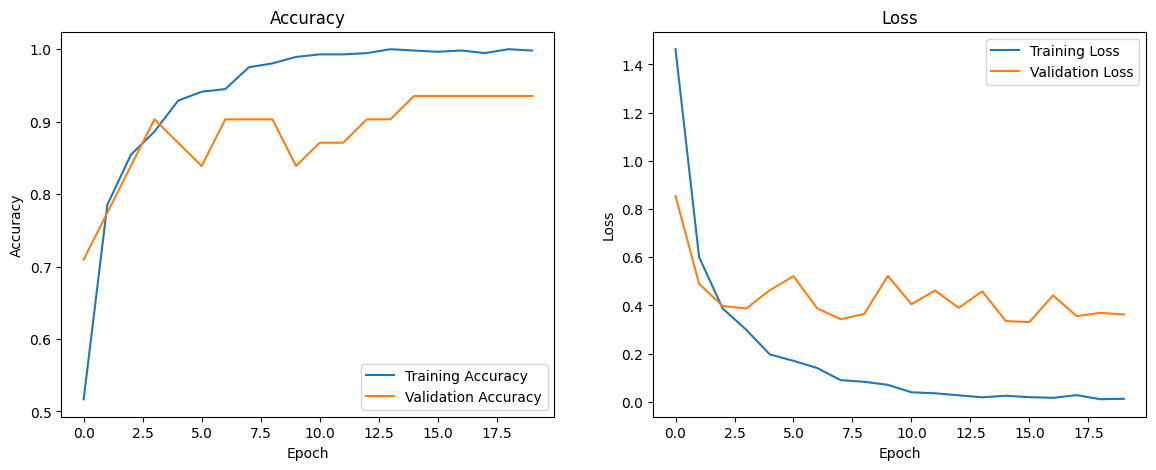

In [ ]:
# Visualize Training Results
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **Testing Model**

### Accuracy

In [ ]:
# Evaluate Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1/1 [==============================] - 1s 1s/step - loss: 0.1544 - accuracy: 0.9375

Test Accuracy: 0.9375
Test Loss: 0.1544


### Test upload file

Saving abrasions (71).jpg to abrasions (71).jpg
Saving mirrored_abrasions (9).jpg to mirrored_abrasions (9).jpg
Saving bruises (85).jpg to bruises (85).jpg
Saving mirrored_bruises (6).jpg to mirrored_bruises (6).jpg
Saving istockphoto-840997336-612x612.jpg to istockphoto-840997336-612x612.jpg
Saving istockphoto-1470816094-612x612.jpg to istockphoto-1470816094-612x612.jpg
Saving mirrored_cut (6).jpg to mirrored_cut (6).jpg
Saving mirrored_cut (22).jpg to mirrored_cut (22).jpg
Saving 92.jpg to 92.jpg
Saving mirrored_26.jpg to mirrored_26.jpg
Saving images (38).jpg to images (38).jpg
Saving images (34).jpg to images (34).jpg
Saving images (33).jpg to images (33).jpg
Saving mirrored_bruises (67).jpg to mirrored_bruises (67).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


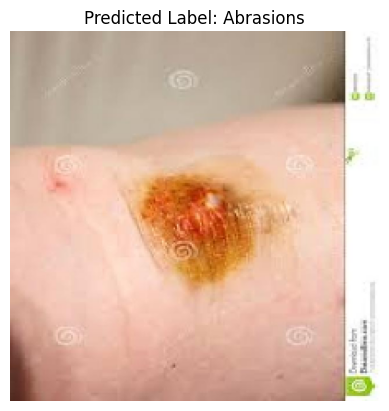

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


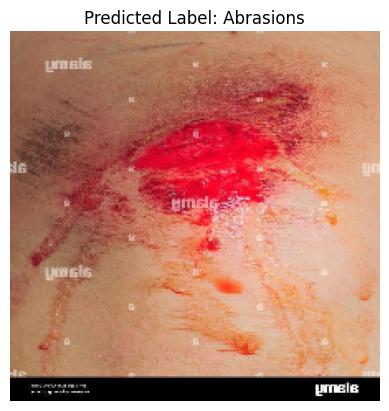

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


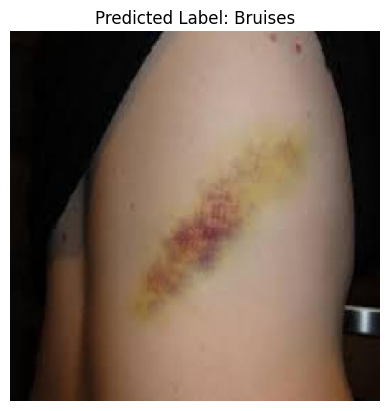

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


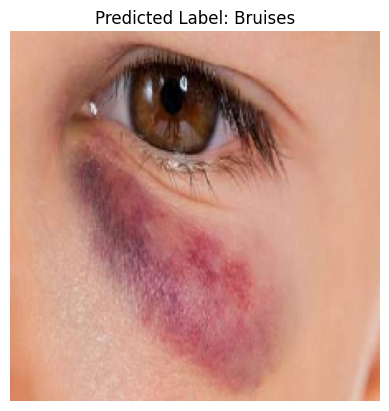

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


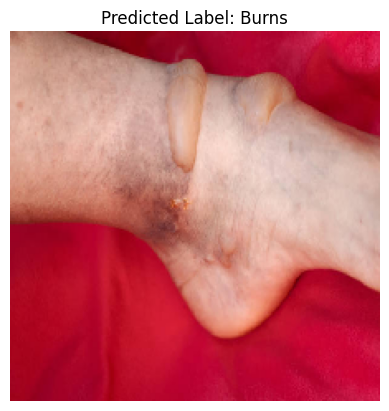

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


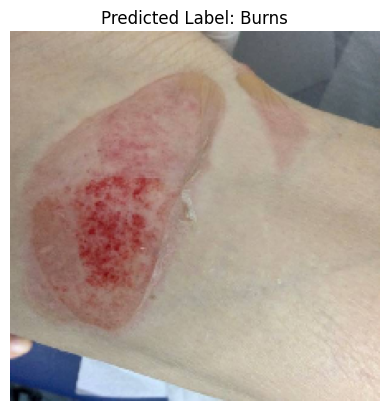

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


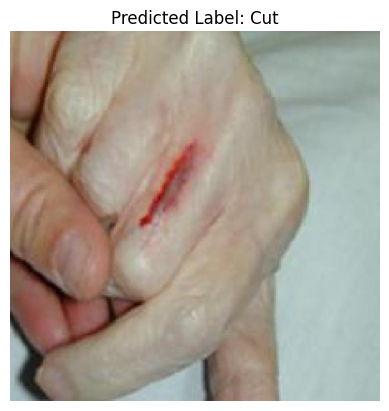

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


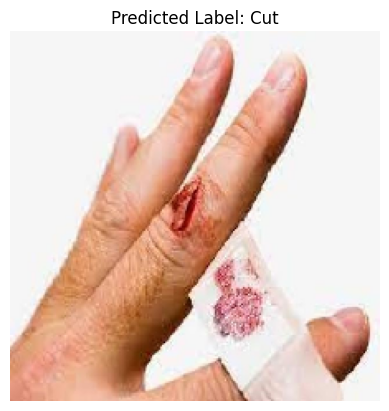

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


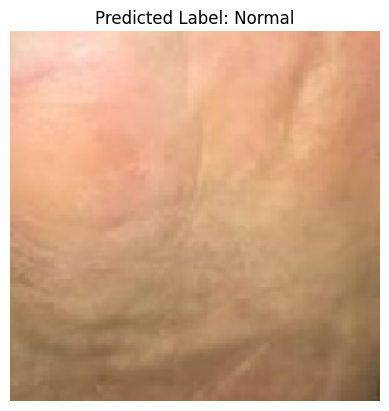

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


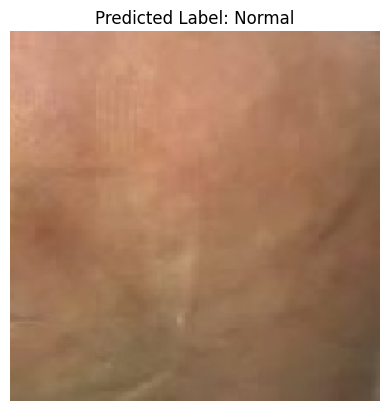

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


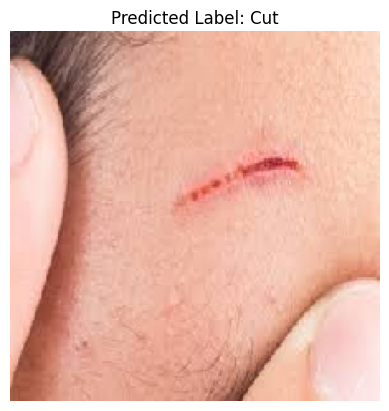

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


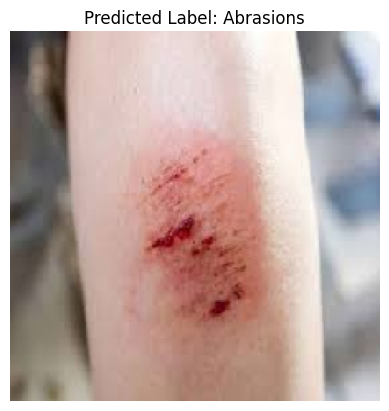

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


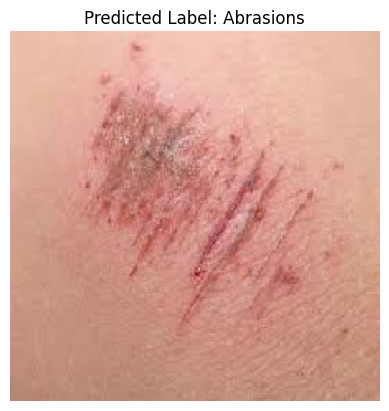

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


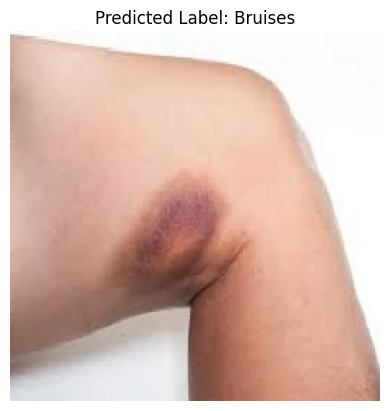

In [ ]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np

# Upload multiple images manually
uploaded = files.upload()

for img_path in uploaded.keys():
   # Load and preprocess the image
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize image

  # Predict the class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

  # Retrieve class label
    class_labels = list(train_generator.class_indices.keys())
    predicted_label = class_labels[predicted_class]

  # Display the result
    plt.figure()
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis("off")
    plt.show()

# **Convert Model**

### Convert Model to .h5

In [ ]:
# Save the model in .h5 format
model.save('wounds_model.h5')
print("Model has been saved as 'wounds_model.h5'")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has been saved as 'wounds_model.h5'


In [ ]:
tf.keras.models.save_model(model, 'wounds_model.keras')

### Convert Model to TensorFlow Lite

In [ ]:
print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.13.0


In [ ]:
import tensorflow as tf

# Define the input and output file names
keras_model_file = "wounds_model.keras"  # Input model in .keras format
tflite_model_file = "wounds_model.tflite"  # Output TFLite model
model = tf.keras.models.load_model(keras_model_file)

# Initialize the TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Apply optimization for smaller model size
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

print(f"Model has been converted to TensorFlow Lite format and saved as '{tflite_model_file}'")

Model has been converted to TensorFlow Lite format and saved as 'wounds_model.tflite'
